In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

#### Data cleaning - oxygen

In [3]:
#ori_data = pd.read_csv('POSE_data.csv')
ori_data = pd.read_csv('BARC_data.csv')
ori_data['time'] = (ori_data['year'].astype(str) + '-' 
                    + ori_data['month'].astype(str) + '-' 
                    + ori_data['day'].astype(str))
ori_data['time'] = pd.to_datetime(ori_data['time'])
ori_data.sort_values(by='time',inplace = True)
ori_data = ori_data[['time', 'dissolvedOxygen', 'groundwaterTempMean']]
ori_data.rename(columns={'groundwaterTempMean':'temperature'}, inplace = True)

In [4]:
MA_data = ori_data[-61:].reset_index(drop=True)
MA_data.head()

,time,dissolvedOxygen,temperature
0,2021-03-01,8.376528,22.891816
1,2021-03-02,8.149479,22.887287
2,2021-03-03,8.199306,22.883634
3,2021-03-04,8.062917,22.876306
4,2021-03-05,8.010139,22.872219


In [5]:
MA_data.describe()

,dissolvedOxygen,temperature
count,61.000000,61.000000
mean,8.074652,22.656316
std,0.279998,0.133095
min,7.512187,22.479688
25%,7.855104,22.519861
50%,8.149479,22.657118
75%,8.297465,22.757516
max,8.566111,22.891816


In [6]:
def relative_time_func(time):
    first_day = pd.to_datetime("2021-02-28")
    time = (pd.to_datetime(time) - first_day) / pd.Timedelta(1, "d")
    return np.asarray(time)

relative_time = relative_time_func(MA_data['time'])
MA_data['relative_time'] = relative_time
MA_data.head()

,time,dissolvedOxygen,temperature,relative_time
0,2021-03-01,8.376528,22.891816,1.0
1,2021-03-02,8.149479,22.887287,2.0
2,2021-03-03,8.199306,22.883634,3.0
3,2021-03-04,8.062917,22.876306,4.0
4,2021-03-05,8.010139,22.872219,5.0


#### Split into training data and test data + Standardization

In [7]:
split_idx = pd.to_datetime(MA_data['time']).searchsorted(pd.to_datetime("2021-04-25"))
training_data = MA_data.iloc[: split_idx, :]
test_data = MA_data.iloc[split_idx:, :].reset_index(drop=True)

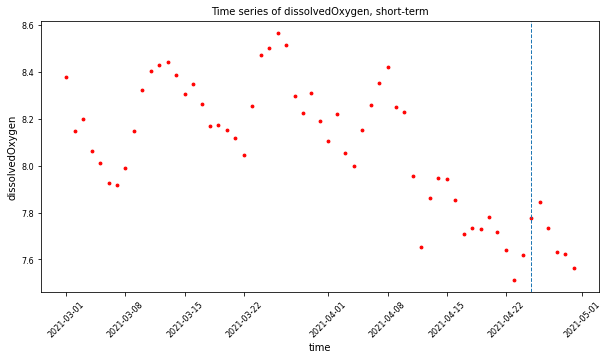

In [8]:
plt.figure(figsize = [10,5])
plt.scatter(MA_data['time'], MA_data['dissolvedOxygen'], s=8, color = 'r')
plt.title('Time series of dissolvedOxygen, short-term', fontsize=10)
plt.xlabel('time', fontsize=10)
plt.ylabel('dissolvedOxygen', fontsize=10)
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(fontsize = 8)

plt.axvline(x=pd.to_datetime("2021-04-25 00:00:00+00:00"), linestyle='--', lw=1);

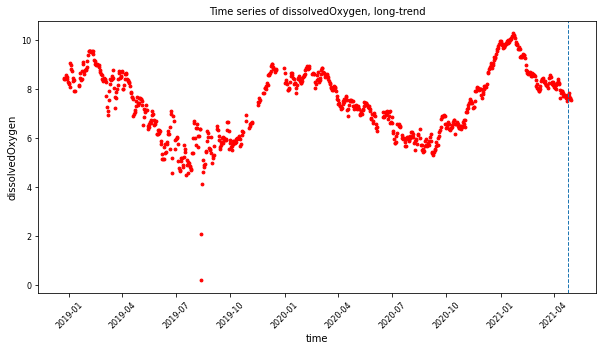

In [9]:
plt.figure(figsize = [10,5])
plt.scatter(ori_data[-800:]['time'], ori_data[-800:]['dissolvedOxygen'], s=8, color = 'r')
plt.title('Time series of dissolvedOxygen, long-trend', fontsize=10)
plt.xlabel('time', fontsize=10)
plt.ylabel('dissolvedOxygen', fontsize=10)
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(fontsize = 8)

plt.axvline(x=pd.to_datetime("2021-04-25 00:00:00+00:00"), linestyle='--', lw=1);

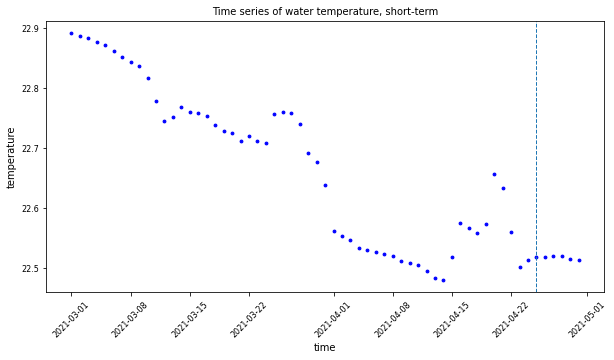

In [10]:
plt.figure(figsize = [10,5])
plt.scatter(MA_data['time'], MA_data['temperature'], s=8, color = 'b')
plt.title('Time series of water temperature, short-term', fontsize=10)
plt.xlabel('time', fontsize=10)
plt.ylabel('temperature', fontsize=10)
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(fontsize = 8)

plt.axvline(x=pd.to_datetime("2021-04-25 00:00:00+00:00"), linestyle='--', lw=1);

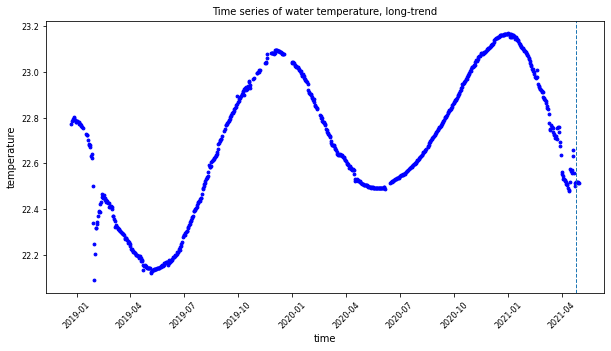

In [11]:
plt.figure(figsize = [10,5])
plt.scatter(ori_data[-800:]['time'], ori_data[-800:]['temperature'], s=8, color = 'b')
plt.title('Time series of water temperature, long-trend', fontsize=10)
plt.xlabel('time', fontsize=10)
plt.ylabel('temperature', fontsize=10)
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(fontsize = 8)

plt.axvline(x=pd.to_datetime("2021-04-25 00:00:00+00:00"), linestyle='--', lw=1);

In [12]:
from sklearn.preprocessing import StandardScaler
features = ['dissolvedOxygen', 'temperature']
new_features = ['std_do', 'std_temp']

sc = StandardScaler()
training_data[new_features] = pd.DataFrame(sc.fit_transform(training_data[features]))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
std_do = np.std(training_data['dissolvedOxygen'])
mean_do = np.mean(training_data['dissolvedOxygen'])

std_temp = np.std(training_data['temperature'])
mean_temp = np.mean(training_data['temperature'])

#### Priors for unknown model parameters

In [14]:
time = training_data["relative_time"].values[:, None]
do = training_data["std_do"].values
temp = training_data["std_temp"].values

In [15]:
with pm.Model() as oxy_model:
  
       #The long-term trend, periodical function
    def mapping(x, T):
        c = 2.0 * np.pi * (1.0 / T)
        u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
        return u
    T, ls = 300, 1
    oxy_exp = pm.gp.cov.ExpQuad(2, ls)
    oxy_cov = pm.gp.cov.WarpedInput(1, cov_func=oxy_exp, warp_func=mapping, args=(T, ))
    M = pm.gp.mean.Linear(coeffs=(do/time).mean())
    oxy_long_gp = pm.gp.Marginal(M, cov_func=oxy_cov)

    
    #The short-term trend - seasonal, cosine function
    ls, tau = 15, 15  #BARC
    #ls, tau = 16, 30  #POSE
    
    oxy_cov = tau * pm.gp.cov.Cosine(1, ls)
    oxy_short_gp = pm.gp.Marginal(M, cov_func=oxy_cov)

    
    oxy_gp = oxy_long_gp + oxy_short_gp
    
    # Noise
    noise = pm.HalfCauchy("noise", 1)

    y_ = oxy_gp.marginal_likelihood("y", X=time, y=do, noise=noise)

    # Find a map
    oxy_mp = pm.find_MAP(include_transformed=True)

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [16]:
with pm.Model() as temp_model:

    # The long-term  trend
    def mapping(x, T):
        c = 2.0 * np.pi * (1.0 / T)
        u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
        return u
    T, ls = 300, 1
    temp_exp = pm.gp.cov.ExpQuad(2, ls)
    temp_cov = pm.gp.cov.WarpedInput(1, cov_func=temp_exp, warp_func=mapping, args=(T, ))
    M = pm.gp.mean.Linear(coeffs=(temp/time).mean())
    temp_long_gp = pm.gp.Marginal(M, cov_func=temp_cov)

#     # The short-term trend - seasonal, cosine function
#     ls, tau = 15, 15
#     temp_cov = tau * pm.gp.cov.Cosine(1, ls)
#     temp_short_gp = pm.gp.Marginal(M, cov_func=temp_cov)
    
    temp_gp = temp_long_gp 

    # Noise
    noise = pm.HalfCauchy("noise",1)

    y_ = temp_gp.marginal_likelihood("y", X=time, y=temp, noise=noise)

    # Find a map
    temp_mp = pm.find_MAP(include_transformed=True)

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


#### for training data

In [17]:
# for training data
dates = pd.date_range(start="2021-03-01", end="2021-04-24", periods=31+24)
train_time = relative_time_func(dates)[:, None]

print("Predicting with oxy_gp ...")
oxy_mu, oxy_var = oxy_gp.predict(train_time, point=oxy_mp, diag=True)
predict_oxy_mu = oxy_mu * std_do + mean_do
predict_oxy_var = oxy_var * std_do ** 2

# make dataframe to store fit results
final_train_oxy = pd.DataFrame(
    {"relative_time": train_time.flatten(), 
     "predict_oxy_mu": predict_oxy_mu, 
     "predict_oxy_std": np.sqrt(predict_oxy_var)}, 
    index=dates
)

final_train_oxy = final_train_oxy.assign(actual_oxy_mu = np.array(training_data["dissolvedOxygen"]))


print("Predicting with temp_gp ...")
temp_mu, temp_var = temp_gp.predict(train_time, point=temp_mp, diag=True)
predict_temp_mu = temp_mu * std_temp + mean_temp
predict_temp_var = temp_var * std_temp ** 2

# make dataframe to store fit results
final_train_temp = pd.DataFrame(
    {"relative_time": train_time.flatten(), 
     "predict_temp_mu": predict_temp_mu, 
     "predict_temp_std": np.sqrt(predict_temp_var)}, 
    index=dates
)

final_train_temp = final_train_temp.assign(actual_temp_mu = np.array(training_data["temperature"]))

print("Done")

Predicting with oxy_gp ...


/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


Predicting with temp_gp ...


/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


Done


In [18]:
final_train_oxy.head()

,relative_time,predict_oxy_mu,predict_oxy_std,actual_oxy_mu
2021-03-01,1.0,8.228437,0.057011,8.376528
2021-03-02,2.0,8.182171,0.053510,8.149479
2021-03-03,3.0,8.144857,0.050877,8.199306
2021-03-04,4.0,8.123781,0.049199,8.062917
2021-03-05,5.0,8.123366,0.048278,8.010139


In [19]:
final_train_temp.head()

,relative_time,predict_temp_mu,predict_temp_std,actual_temp_mu
2021-03-01,1.0,22.882381,0.016904,22.891816
2021-03-02,2.0,22.875604,0.015891,22.887287
2021-03-03,3.0,22.868574,0.014947,22.883634
2021-03-04,4.0,22.861302,0.014073,22.876306
2021-03-05,5.0,22.853800,0.013272,22.872219


In [20]:
train_uncertainty_up_oxy = final_train_oxy.predict_oxy_mu + 1.96 * final_train_oxy.predict_oxy_std
train_uncertainty_low_oxy = final_train_oxy.predict_oxy_mu - 1.96 * final_train_oxy.predict_oxy_std

train_uncertainty_up_temp = final_train_temp.predict_temp_mu + 1.96 * final_train_temp.predict_temp_std
train_uncertainty_low_temp = final_train_temp.predict_temp_mu - 1.96 * final_train_temp.predict_temp_std

#### For test data

In [21]:
dates = pd.date_range(start="2021-04-25", end="2021-04-30", periods = 6)
test_time = relative_time_func(dates)[:, None]

print("Sampling gp predictions for dissolved oxygen.")
oxy_mu, oxy_cov = oxy_gp.predict(test_time, point=oxy_mp)
oxy_mu, oxy_var = oxy_gp.predict(test_time, point=oxy_mp, diag=True)
predict_oxy_mu = oxy_mu * std_do + mean_do
predict_oxy_var = oxy_var * std_do ** 2

final_prediction_oxy = pd.DataFrame(
    {"relative_time": test_time.flatten(), 
     "predict_oxy_mu": predict_oxy_mu, 
     "predict_oxy_std": np.sqrt(predict_oxy_var)}, 
    index=dates
)

print("Sampling gp predictions for temperature.")
temp_mu, temp_var = temp_gp.predict(test_time, point=temp_mp, diag=True)
predict_temp_mu = temp_mu * std_temp + mean_temp
predict_temp_var = temp_var * std_temp ** 2

final_prediction_temp = pd.DataFrame(
    {"relative_time": test_time.flatten(), 
     "predict_temp_mu": predict_temp_mu, 
     "predict_temp_std": np.sqrt(predict_temp_var)}, 
    index=dates
)

Sampling gp predictions for dissolved oxygen.


/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


Sampling gp predictions for temperature.


In [22]:
final_prediction_oxy

,relative_time,predict_oxy_mu,predict_oxy_std
2021-04-25,56.0,7.885519,0.061005
2021-04-26,57.0,7.884787,0.064996
2021-04-27,58.0,7.862426,0.068554
2021-04-28,59.0,7.819569,0.071443
2021-04-29,60.0,7.760947,0.073650
2021-04-30,61.0,7.694075,0.075339


In [23]:
final_prediction_temp

,relative_time,predict_temp_mu,predict_temp_std
2021-04-25,56.0,22.523820,0.017984
2021-04-26,57.0,22.523735,0.019126
2021-04-27,58.0,22.523928,0.020329
2021-04-28,59.0,22.524391,0.021589
2021-04-29,60.0,22.525113,0.022904
2021-04-30,61.0,22.526084,0.024272


In [24]:
test_uncertainty_up_oxy = final_prediction_oxy.predict_oxy_mu + 1.96 * final_prediction_oxy.predict_oxy_std
test_uncertainty_low_oxy = final_prediction_oxy.predict_oxy_mu - 1.96 * final_prediction_oxy.predict_oxy_std

test_uncertainty_up_temp = final_prediction_temp.predict_temp_mu + 1.96 * final_prediction_temp.predict_temp_std
test_uncertainty_low_temp = final_prediction_temp.predict_temp_mu - 1.96 * final_prediction_temp.predict_temp_std

In [25]:
all_time = list(training_data['time']) + list(dates)
all_predict_oxy_mu = list(final_train_oxy['predict_oxy_mu'].values) + list(final_prediction_oxy['predict_oxy_mu'].values)
all_actual_oxy = list(MA_data['dissolvedOxygen'])
all_uncertainty_up_oxy = list(train_uncertainty_up_oxy.values) + list(test_uncertainty_up_oxy)
all_uncertainty_low_oxy = list(train_uncertainty_low_oxy.values) + list(test_uncertainty_low_oxy)

all_time = list(training_data['time']) + list(dates)
all_predict_temp_mu = list(final_train_temp['predict_temp_mu'].values) + list(final_prediction_temp['predict_temp_mu'].values)
all_actual_temp = list(MA_data['temperature'])
all_uncertainty_up_temp = list(train_uncertainty_up_temp.values) + list(test_uncertainty_up_temp)
all_uncertainty_low_temp = list(train_uncertainty_low_temp.values) + list(test_uncertainty_low_temp)

In [26]:
from sklearn.metrics import mean_squared_error
print('MSE of training-dissolvedOxygen is %s' %mean_squared_error(final_train_oxy['actual_oxy_mu'],
                                                                  final_train_oxy['predict_oxy_mu']))

print('MSE of training-temperature is %s' %round(mean_squared_error(final_train_temp['actual_temp_mu'],
                                                                    final_train_temp['predict_temp_mu']),4))

MSE of training-dissolvedOxygen is 0.0238670713761444
MSE of training-temperature is 0.0023


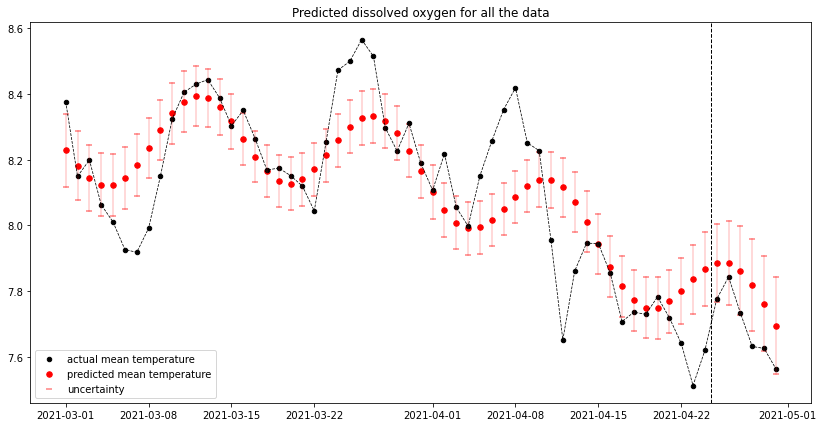

In [27]:
plt.figure(figsize=[14,7])

predict_oxy = plt.scatter(all_time, all_predict_oxy_mu, c='r', s=30)
plt.title('Predicted dissolved oxygen for all the data')

scatter_uncertainty1 = plt.scatter(all_time, all_uncertainty_up_oxy, color='r', marker='_', alpha=0.5)
scatter_uncertainty2 = plt.scatter(all_time, all_uncertainty_low_oxy,color='r', marker='_', alpha=0.5)

for i in range(len(all_time)):
    x = [all_time[i], all_time[i]]
    y = [all_uncertainty_up_oxy[i], all_uncertainty_low_oxy[i]]
    plt.plot(x,y,color = 'r', alpha=0.2)

#Actual data
actual_data = plt.scatter(MA_data['time'], all_actual_oxy, color="black", s=20)
plt.plot(MA_data['time'], all_actual_oxy, linestyle='--', color="black", lw=0.75)
plt.legend([actual_data, predict_oxy, scatter_uncertainty1], ['actual mean temperature', 
                                                              'predicted mean temperature',
                                                              'uncertainty'])
plt.axvline(x=pd.to_datetime("2021-04-24 12:00:00+00:00"), color = 'black',linestyle='--', lw=1);

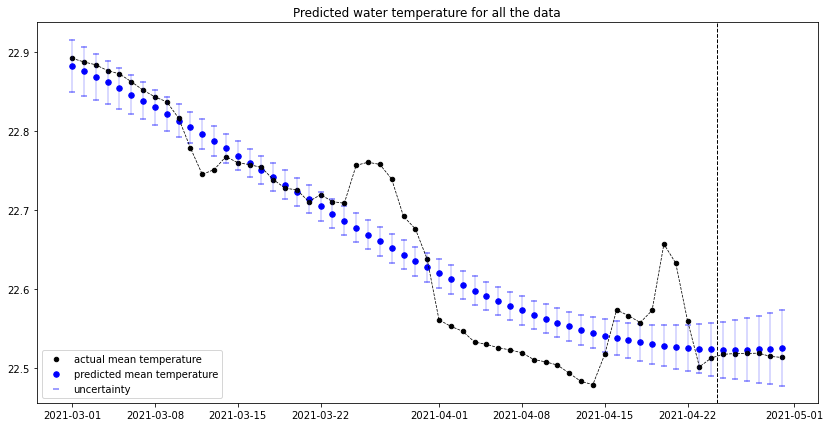

In [28]:
plt.figure(figsize=[14,7])

predict_temp = plt.scatter(all_time, all_predict_temp_mu, c='b', s=30)
plt.title('Predicted water temperature for all the data')

scatter_uncertainty1 = plt.scatter(all_time, all_uncertainty_up_temp, color='b', marker='_', alpha=0.5)
scatter_uncertainty2 = plt.scatter(all_time, all_uncertainty_low_temp, color='b', marker='_', alpha=0.5)

for i in range(len(all_time)):
    x = [all_time[i], all_time[i]]
    y = [all_uncertainty_up_temp[i], all_uncertainty_low_temp[i]]
    plt.plot(x,y,color = 'b', alpha=0.2)

#Actual data
actual_data = plt.scatter(MA_data['time'], all_actual_temp, color="black", s=20)
plt.plot(MA_data['time'], all_actual_temp, linestyle='--', color="black", lw=0.75)
plt.legend([actual_data, predict_temp, scatter_uncertainty1], ['actual mean temperature', 
                                                               'predicted mean temperature',
                                                               'uncertainty'])
plt.axvline(x=pd.to_datetime("2021-04-24 12:00:00+00:00"), color = 'black',linestyle='--', lw=1);

In [29]:
def export_oxy(siteID):
    
    # import data
    ori_data = pd.read_csv(siteID)
    ori_data['time'] = (ori_data['year'].astype(str) + '-' 
                        + ori_data['month'].astype(str) + '-' 
                        + ori_data['day'].astype(str))
    ori_data['time'] = pd.to_datetime(ori_data['time'])
    ori_data.sort_values(by='time',inplace = True)
    ori_data = ori_data[['time', 'dissolvedOxygen', 'groundwaterTempMean']]
    ori_data.rename(columns={'groundwaterTempMean':'temperature'}, inplace = True)
    
    MA_data = ori_data[-61:].reset_index(drop=True)
    
    def relative_time_func(time):
        first_day = pd.to_datetime("2021-02-28")
        time = (pd.to_datetime(time) - first_day) / pd.Timedelta(1, "d")
        return np.asarray(time)

    relative_time = relative_time_func(MA_data['time'])
    MA_data['relative_time'] = relative_time
    
    
    # standardization
    training_data = MA_data
    
    from sklearn.preprocessing import StandardScaler
    features, new_features = ['dissolvedOxygen', 'temperature'], ['std_do', 'std_temp']

    sc = StandardScaler()
    training_data[new_features] = pd.DataFrame(sc.fit_transform(training_data[features]))    
    std_do, mean_do = np.std(training_data['dissolvedOxygen']),np.mean(training_data['dissolvedOxygen'])
    
    
    # Priors for unknown model parameters
    time = training_data["relative_time"].values[:, None]
    do = training_data["std_do"].values
    
    with pm.Model() as oxy_model:
  
       #The long-term trend, periodical function
        def mapping(x, T):
            c = 2.0 * np.pi * (1.0 / T)
            u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
            return u
        T, ls = 300, 1
        oxy_exp = pm.gp.cov.ExpQuad(2, ls)
        oxy_cov = pm.gp.cov.WarpedInput(1, cov_func=oxy_exp, warp_func=mapping, args=(T, ))
        M = pm.gp.mean.Linear(coeffs=(do/time).mean())
        oxy_long_gp = pm.gp.Marginal(M, cov_func=oxy_cov)

        #The short-term trend - seasonal, cosine function
        if siteID == 'BARC_data.csv':
            ls, tau = 15, 15  #BARC
        elif siteID == 'POSE_data.csv':
            ls, tau = 16, 30
        oxy_cov = tau * pm.gp.cov.Cosine(1, ls)
        oxy_short_gp = pm.gp.Marginal(M, cov_func=oxy_cov)
    
        oxy_gp = oxy_long_gp + oxy_short_gp
    
        # Noise
        noise = pm.HalfCauchy("noise", 1)

        y_ = oxy_gp.marginal_likelihood("y", X=time, y=do, noise=noise)

        # Find a map
        oxy_mp = pm.find_MAP(include_transformed=True)
    
    
    
    # for training data
    dates = pd.date_range(start="2021-03-01", end="2021-04-30", periods=31+30)
    train_time = relative_time_func(dates)[:, None]

    print("Predicting with oxy_gp ...")
    oxy_mu, oxy_var = oxy_gp.predict(train_time, point=oxy_mp, diag=True)
    predict_oxy_mu = oxy_mu * std_do + mean_do
    predict_oxy_var = oxy_var * std_do ** 2

    # make dataframe to store fit results
    final_train = pd.DataFrame(
        {"relative_time": train_time.flatten(), "predict_oxy_mu": predict_oxy_mu, 
         "predict_oxy_std": np.sqrt(predict_oxy_var)}, index=dates)

    final_train = final_train.assign(actual_oxy_mu = np.array(training_data["dissolvedOxygen"]))
    print("Done")
    
    train_uncertainty_up_oxy = final_train.predict_oxy_mu + 1.96 * final_train.predict_oxy_std
    train_uncertainty_low_oxy = final_train.predict_oxy_mu - 1.96 * final_train.predict_oxy_std
    
    
    # for test data
    dates = pd.date_range(start="2021-05-01", end="2021-05-07", periods = 7)
    test_time = relative_time_func(dates)[:, None]

    print("Sampling gp predictions for dissolved oxygen.")
    #oxy_mu, oxy_cov = oxy_gp.predict(test_time, point=oxy_mp)
    oxy_mu, oxy_var = oxy_gp.predict(test_time, point=oxy_mp, diag=True)
    predict_oxy_mu = oxy_mu * std_do + mean_do
    predict_oxy_var = oxy_var * std_do ** 2

    final_prediction = pd.DataFrame(
        {"relative_time": test_time.flatten(), "predict_oxy_mu": predict_oxy_mu, 
         "predict_oxy_std": np.sqrt(predict_oxy_var)}, index=dates)
    
    test_uncertainty_up_oxy = final_prediction.predict_oxy_mu + 1.96 * final_prediction.predict_oxy_std
    test_uncertainty_low_oxy = final_prediction.predict_oxy_mu - 1.96 * final_prediction.predict_oxy_std
    
    
    
    # final csv and plot
    all_time = list(training_data['time']) + list(dates)

    all_predict_oxy_mu = list(final_train['predict_oxy_mu'].values) + list(final_prediction['predict_oxy_mu'].values)
    all_actual_oxy = list(training_data['dissolvedOxygen'])

    all_uncertainty_up_oxy = list(train_uncertainty_up_oxy.values) + list(test_uncertainty_up_oxy)
    all_uncertainty_low_oxy = list(train_uncertainty_low_oxy.values) + list(test_uncertainty_low_oxy)
    
    plt.figure(figsize=[14,7])
    predict_oxy = plt.scatter(all_time, all_predict_oxy_mu, c='r', s=30)
    if siteID == 'BARC_data.csv':
        plt.title('Predicted dissolved oxygen for all the data (BARC)' )
    elif siteID == 'POSE_data.csv':
        plt.title('Predicted dissolved oxygen for all the data (POSE)' )


    scatter_uncertainty1 = plt.scatter(all_time, all_uncertainty_up_oxy, color='r', marker='_', alpha=0.5)
    scatter_uncertainty2 = plt.scatter(all_time, all_uncertainty_low_oxy,color='r', marker='_', alpha=0.5)

    for i in range(len(all_time)):
        x = [all_time[i], all_time[i]]
        y = [all_uncertainty_up_oxy[i], all_uncertainty_low_oxy[i]]
        plt.plot(x,y,color = 'r', alpha=0.2)

    #Actual data
    actual_data = plt.scatter(training_data['time'], all_actual_oxy, color="black", s=20)
    plt.plot(training_data['time'], all_actual_oxy, linestyle='--', color="black", lw=0.75)
    plt.legend([actual_data, predict_oxy, scatter_uncertainty1], ['actual mean temperature', 
                                                                  'predicted mean temperature',
                                                                  'uncertainty'])
    plt.axvline(x=pd.to_datetime("2021-04-30 12:00:00+00:00"), color = 'black',linestyle='--', lw=1);
    
    return final_prediction

In [30]:
def export_temp(siteID):
    
    # import data
    ori_data = pd.read_csv(siteID)
    ori_data['time'] = (ori_data['year'].astype(str) + '-' 
                        + ori_data['month'].astype(str) + '-' 
                        + ori_data['day'].astype(str))
    ori_data['time'] = pd.to_datetime(ori_data['time'])
    ori_data.sort_values(by='time',inplace = True)
    ori_data = ori_data[['time', 'dissolvedOxygen', 'groundwaterTempMean']]
    ori_data.rename(columns={'groundwaterTempMean':'temperature'}, inplace = True)
    
    MA_data = ori_data[-61:].reset_index(drop=True)
    
    def relative_time_func(time):
        first_day = pd.to_datetime("2021-02-28")
        time = (pd.to_datetime(time) - first_day) / pd.Timedelta(1, "d")
        return np.asarray(time)

    relative_time = relative_time_func(MA_data['time'])
    MA_data['relative_time'] = relative_time
    
    
    # standardization
    training_data = MA_data
    
    from sklearn.preprocessing import StandardScaler
    features, new_features = ['dissolvedOxygen', 'temperature'], ['std_do', 'std_temp']

    sc = StandardScaler()
    training_data[new_features] = pd.DataFrame(sc.fit_transform(training_data[features]))    
    std_temp, mean_temp = np.std(training_data['temperature']),np.mean(training_data['temperature'])
    
    
    # Priors for unknown model parameters
    time = training_data["relative_time"].values[:, None]
    temp = training_data["std_temp"].values
    
    with pm.Model() as oxy_model:
         # The long-term  trend
        def mapping(x, T):
            c = 2.0 * np.pi * (1.0 / T)
            u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
            return u
        T, ls = 300, 1
        temp_exp = pm.gp.cov.ExpQuad(2, ls)
        temp_cov = pm.gp.cov.WarpedInput(1, cov_func=temp_exp, warp_func=mapping, args=(T, ))
        M = pm.gp.mean.Linear(coeffs=(temp/time).mean())
        temp_long_gp = pm.gp.Marginal(M, cov_func=temp_cov)

#         # The short-term trend - seasonal, cosine function
#         ls, tau = 16, 30
#         temp_cov = tau * pm.gp.cov.Cosine(1, ls)
#         temp_short_gp = pm.gp.Marginal(M, cov_func=temp_cov)
    
        temp_gp = temp_long_gp

        # Noise
        noise = pm.HalfCauchy("noise",1)

        y_ = temp_gp.marginal_likelihood("y", X=time, y=temp, noise=noise)

        # Find a map
        temp_mp = pm.find_MAP(include_transformed=True)
    
    
    # for training data
    dates = pd.date_range(start="2021-03-01", end="2021-04-30", periods=31+30)
    train_time = relative_time_func(dates)[:, None]

    print("Predicting with temp_gp ...")
    temp_mu, temp_var = temp_gp.predict(train_time, point=temp_mp, diag=True)
    predict_temp_mu = temp_mu * std_temp + mean_temp
    predict_temp_var = temp_var * std_temp ** 2

    # make dataframe to store fit results
    final_train = pd.DataFrame(
        {"relative_time": train_time.flatten(), "predict_temp_mu": predict_temp_mu, 
         "predict_temp_std": np.sqrt(predict_temp_var)}, index=dates)

    final_train = final_train.assign(actual_temp_mu = np.array(training_data["temperature"]))
    print("Done")
    
    train_uncertainty_up_temp = final_train.predict_temp_mu + 1.96 * final_train.predict_temp_std
    train_uncertainty_low_temp = final_train.predict_temp_mu - 1.96 * final_train.predict_temp_std
    
    
    # for test data
    dates = pd.date_range(start="2021-05-01", end="2021-05-07", periods = 7)
    test_time = relative_time_func(dates)[:, None]

    print("Sampling gp predictions for temperature.")
    temp_mu, temp_var = temp_gp.predict(test_time, point=temp_mp, diag=True)
    predict_temp_mu = temp_mu * std_temp + mean_temp
    predict_temp_var = temp_var * std_temp ** 2

    final_prediction = pd.DataFrame(
        {"relative_time": test_time.flatten(),"predict_temp_mu": predict_temp_mu,
         "predict_temp_std": np.sqrt(predict_temp_var)}, index=dates)

    test_uncertainty_up_temp = final_prediction.predict_temp_mu + 1.96 * final_prediction.predict_temp_std
    test_uncertainty_low_temp = final_prediction.predict_temp_mu - 1.96 * final_prediction.predict_temp_std
    
    
    # final csv and plot
    all_time = list(training_data['time']) + list(dates)
    all_predict_temp_mu = list(final_train['predict_temp_mu'].values) + list(final_prediction['predict_temp_mu'].values)
    all_actual_temp = list(training_data['temperature']) 
    all_uncertainty_up_temp = list(train_uncertainty_up_temp.values) + list(test_uncertainty_up_temp)
    all_uncertainty_low_temp = list(train_uncertainty_low_temp.values) + list(test_uncertainty_low_temp)
    
    plt.figure(figsize=[14,7])

    predict_temp = plt.scatter(all_time, all_predict_temp_mu, c='b', s=30)
    if siteID == 'BARC_data.csv':
        plt.title('Predicted water temperature for all the data (BARC)' )
    elif siteID == 'POSE_data.csv':
        plt.title('Predicted water temperature for all the data (POSE)' )

    scatter_uncertainty1 = plt.scatter(all_time, all_uncertainty_up_temp, color='b', marker='_', alpha=0.5)
    scatter_uncertainty2 = plt.scatter(all_time, all_uncertainty_low_temp, color='b', marker='_', alpha=0.5)

    for i in range(len(all_time)):
        x = [all_time[i], all_time[i]]
        y = [all_uncertainty_up_temp[i], all_uncertainty_low_temp[i]]
        plt.plot(x,y,color = 'b', alpha=0.2)

    #Actual data
    actual_data = plt.scatter(training_data['time'], all_actual_temp, color="black", s=20)
    plt.plot(training_data['time'], all_actual_temp, linestyle='--', color="black", lw=0.75)
    plt.legend([actual_data, predict_temp, scatter_uncertainty1], ['actual mean temperature', 
                                                                   'predicted mean temperature',
                                                                   'uncertainty'])
    plt.axvline(x=pd.to_datetime("2021-04-30 12:00:00+00:00"), color = 'black',linestyle='--', lw=1);
    
    return final_prediction

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(



Predicting with oxy_gp ...
Done
Sampling gp predictions for dissolved oxygen.


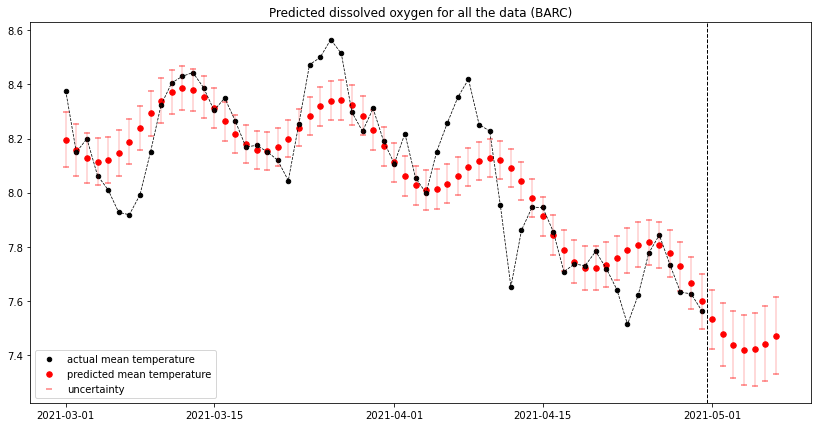

In [31]:
oxy_BARC = export_oxy('BARC_data.csv')

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(



Predicting with oxy_gp ...
Done
Sampling gp predictions for dissolved oxygen.


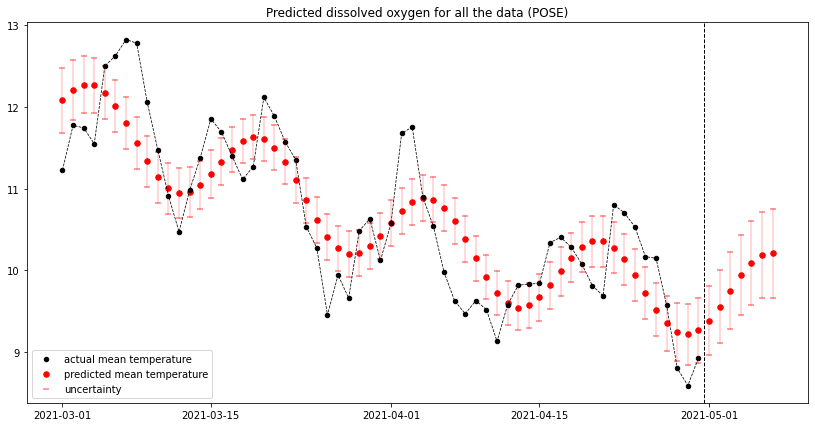

In [32]:
oxy_POSE = export_oxy('POSE_data.csv')

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(



Predicting with temp_gp ...
Done
Sampling gp predictions for temperature.


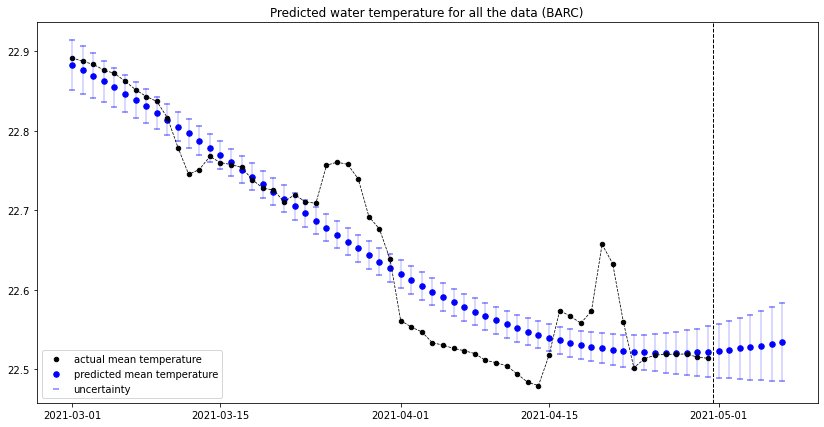

In [33]:
temp_BARC = export_temp('BARC_data.csv')

/opt/anaconda3/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(



Predicting with temp_gp ...
Done
Sampling gp predictions for temperature.


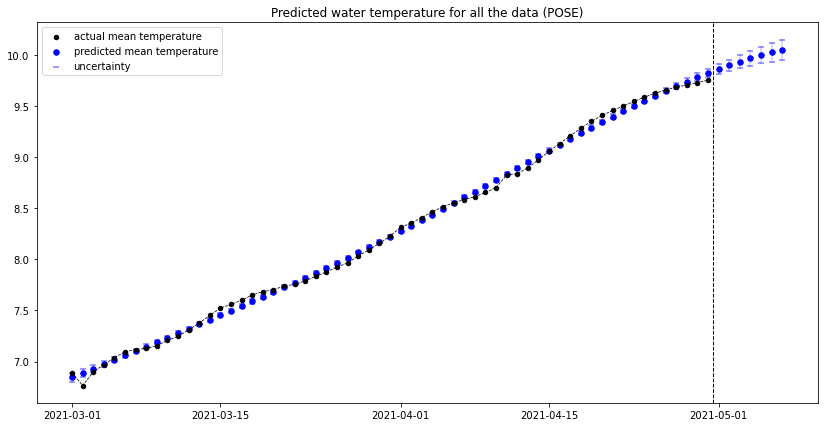

In [34]:
temp_POSE = export_temp('POSE_data.csv')

In [35]:
BARC_oxy_mean = pd.DataFrame({'oxygen':oxy_BARC['predict_oxy_mu'], 'statistic':'mean'})
BARC_oxy_std = pd.DataFrame({'oxygen':oxy_BARC['predict_oxy_std'], 'statistic':'sd'})
BARC_oxy = pd.concat([BARC_oxy_mean, BARC_oxy_std])
BARC_oxy = BARC_oxy.assign(siteID = 'BARC')

POSE_oxy_mean = pd.DataFrame({'oxygen':oxy_POSE['predict_oxy_mu'], 'statistic':'mean'})
POSE_oxy_std = pd.DataFrame({'oxygen':oxy_POSE['predict_oxy_std'], 'statistic':'sd'})
POSE_oxy = pd.concat([POSE_oxy_mean, POSE_oxy_std])
POSE_oxy = POSE_oxy.assign(siteID = 'POSE')

BARC_temp_mean = pd.DataFrame({'temperature':temp_BARC['predict_temp_mu'], 'statistic':'mean'})
BARC_temp_std = pd.DataFrame({'temperature':temp_BARC['predict_temp_std'], 'statistic':'sd'})
BARC_temp = pd.concat([BARC_temp_mean, BARC_temp_std])
BARC_temp = BARC_temp.assign(siteID = 'BARC')

POSE_temp_mean = pd.DataFrame({'temperature':temp_POSE['predict_temp_mu'], 'statistic':'mean'})
POSE_temp_std = pd.DataFrame({'temperature':temp_POSE['predict_temp_std'], 'statistic':'sd'})
POSE_temp = pd.concat([POSE_temp_mean, POSE_temp_std])
POSE_temp = POSE_temp.assign(siteID = 'POSE')

oxygen = pd.concat([BARC_oxy, POSE_oxy])
temperature = pd.concat([BARC_temp, POSE_temp])

final_export = oxygen.copy()
final_export['temperature'] = temperature['temperature']
final_export.reset_index(drop=False, inplace = True)
final_export.sort_values(by=['index', 'siteID'], inplace = True)
final_export.reset_index(drop=True, inplace = True)
final_export.rename(columns={'index':'time'}, inplace = True)

In [36]:
final_export = final_export.assign(obs_flag = 2.0, forecast = 1.0, data_assimilation = 0.0)
cols = ['time', 'statistic', 'siteID', 'oxygen', 'temperature', 'obs_flag', 'forecast', 'data_assimilation']
final_export = final_export[cols]
final_export

,time,statistic,siteID,oxygen,temperature,obs_flag,forecast,data_assimilation
0,2021-05-01,mean,BARC,7.531158,22.523468,2.0,1.0,0.0
1,2021-05-01,sd,BARC,0.055476,0.017253,2.0,1.0,0.0
2,2021-05-01,mean,POSE,9.385870,9.859685,2.0,1.0,0.0
3,2021-05-01,sd,POSE,0.215399,0.024303,2.0,1.0,0.0
4,2021-05-02,mean,BARC,7.475655,22.524762,2.0,1.0,0.0
5,2021-05-02,sd,BARC,0.059194,0.018376,2.0,1.0,0.0
6,2021-05-02,mean,POSE,9.557116,9.896497,2.0,1.0,0.0
7,2021-05-02,sd,POSE,0.228654,0.027758,2.0,1.0,0.0
8,2021-05-03,mean,BARC,7.436923,22.526270,2.0,1.0,0.0
9,2021-05-03,sd,BARC,0.062787,0.019563,2.0,1.0,0.0


In [38]:
final_export.to_csv('Aquatics-2021-05-01-wbears_gp.csv', index=False)